number of iterations

precision

number of function evaluations

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import math
import sys

%matplotlib inline

plt.style.use(['ggplot'])

## Random data generation

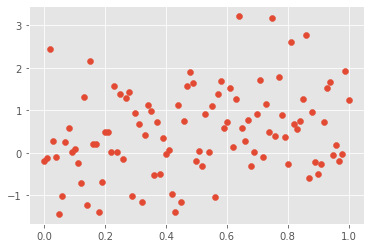

In [2]:
import random
alpha = random.random()
beta = random.random()

X = np.array([k/100.0 for k in range(101)])
deltas = np.random.normal(0, 1, 101)
Y = np.array([alpha*X[k]+beta+deltas[k] for k in range(101)])

plt.scatter(X, Y)
plt.savefig('data_mu1.png')

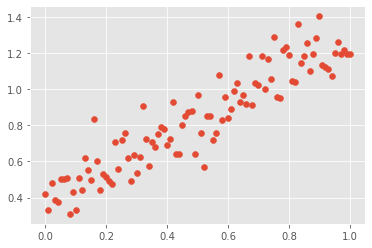

In [3]:
alpha = random.random()
beta = random.random()

X = np.array([k/100.0 for k in range(101)])
deltas = np.random.normal(0, 0.1, 101)
Y = np.array([alpha*X[k]+beta+deltas[k] for k in range(X.shape[0])])

plt.scatter(X, Y)
plt.savefig('data01.png')

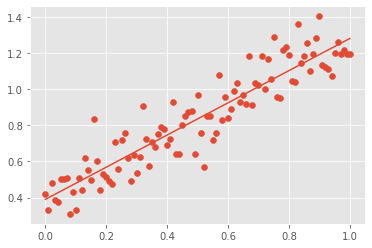

In [4]:
def plot_aproximant(f, data_X=X, data_Y=Y):
    plt.scatter(data_X, data_Y)
    plt.plot(data_X, [f(x) for x in X])
    
# Here, we plot the data and the alpha*x+beta linear function 
plot_aproximant(lambda x: alpha*x+beta, X, Y)

In [5]:
def least_squares(F, a, b):
    return sum([(F(X[k], a, b)-Y[k])**2 for k in range(X.shape[0])])

least_squares(lambda x, a, b: a*x+b, alpha, beta)

1.1265486611560398

In [6]:
def linear_approximant(x, a=0.0, b=0.0):
    return a*x+b

def rational_approximant(x, a=0.0, b=0.0):
    return a/(1+b*x)

     fun: 1.126366117276201
     jac: array([0.0183924, 0.049772 ])
 message: 'Desired error not necessarily achieved due to precision loss.'
    nfev: 162
     nit: 2
    njev: 50
  status: 2
 success: False
       x: array([0.89417523, 0.38693928])


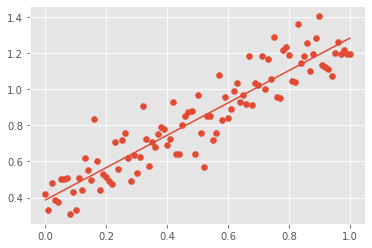

In [7]:
import scipy.optimize as opt

def gauss(F, a0=0.0, b0=0.0, eps = 0.001):
    res = opt.minimize(lambda x: least_squares(F, x[0], x[1]), x0=(a0, b0), method='CG', options={'eps': eps})
    return res

estimation_gauss_lin = gauss(linear_approximant)

print(estimation_gauss_lin)
plot_aproximant(lambda x: linear_approximant(x, estimation_gauss_lin.x[0], estimation_gauss_lin.x[1]))
plt.show()

In [8]:
import numpy as np
import matplotlib.pyplot as plot

# Реализация взята с https://habr.com/ru/post/547424/

def example_function(x, y):
    return np.sin(x) * np.exp((1 - np.cos(y)) ** 2) + \
           np.cos(y) * np.exp((1 - np.sin(x)) ** 2) + (x - y) ** 2
n_steps = 0
n_function_callings = 0
def custom_gradient(differentiable_function, global_epsilon=0.001, centre=(0.001, 0.001), radius = 8, arr_shape=100, log = False, draw=False):

    step = radius / arr_shape

    def rotate_vector(length, a):
        return length * np.cos(a), length * np.sin(a)


    def derivative_x(epsilon, arg):
        global n_function_callings
        n_function_callings+=2
        return (differentiable_function(global_epsilon + epsilon, arg) -
                differentiable_function(epsilon, arg)) / global_epsilon


    def derivative_y(epsilon, arg):
        global n_function_callings
        n_function_callings+=2
        return (differentiable_function(arg, epsilon + global_epsilon) -
                differentiable_function(arg, epsilon)) / global_epsilon


    def calculate_flip_points():
        flip_points = np.array([0, 0])
        points = np.zeros((360, arr_shape), dtype=bool)
        cx, cy = centre

        for i in range(arr_shape):
            for alpha in range(360):
                x, y = rotate_vector(step, alpha)
                x = x * i + cx
                y = y * i + cy
                points[alpha][i] = derivative_x(x, y) + derivative_y(y, x) > 0
                if not points[alpha][i - 1] and points[alpha][i]:
                    flip_points = np.vstack((flip_points, np.array([alpha, i - 1])))
        return flip_points


    def pick_estimates(positions):
        global n_function_callings
        vx, vy = rotate_vector(step, positions[1][0])
        cx, cy = centre
        best_x, best_y = cx + vx * positions[1][1], cy + vy * positions[1][1]

        for index in range(2, len(positions)):
            vx, vy = rotate_vector(step, positions[index][0])
            x, y = cx + vx * positions[index][1], cy + vy * positions[index][1]
            n_function_callings+=2
            if differentiable_function(best_x, best_y) > differentiable_function(x, y):
                best_x = x
                best_y = y

        for index in range(360):
            vx, vy = rotate_vector(step, index)
            x, y = cx + vx * (arr_shape - 1), cy + vy * (arr_shape - 1)
            n_function_callings+=2
            if differentiable_function(best_x, best_y) > differentiable_function(x, y):
                best_x = x
                best_y = y

        return best_x, best_y


    def gradient_descent(best_estimates, is_x):
        global n_steps
        derivative = derivative_x if is_x else derivative_y
        best_x, best_y = best_estimates
        descent_step = step
        value = derivative(best_y, best_x)
        steps = 0
        while abs(value) > global_epsilon:
            descent_step *= 0.95
            best_y = best_y - descent_step if derivative(best_y, best_x) > 0 else best_y + descent_step
            value = derivative(best_y, best_x)
            steps+=1
        n_steps+=steps
        return best_y, best_x


    def find_minimum():
        return gradient_descent(gradient_descent(pick_estimates(calculate_flip_points()), False), True)


    def get_grid(grid_step):
        samples = np.arange(-radius, radius, grid_step)
        x, y = np.meshgrid(samples, samples)
        return x, y, differentiable_function(x, y)


    def draw_chart(point, grid):
        point_x, point_y, point_z = point
        grid_x, grid_y, grid_z = grid
        plot.rcParams.update({
            'figure.figsize': (4, 4),
            'figure.dpi': 200,
            'xtick.labelsize': 4,
            'ytick.labelsize': 4
        })
        ax = plot.figure().add_subplot(111, projection='3d')
        ax.scatter(point_x, point_y, point_z, color='red')
        ax.plot_surface(grid_x, grid_y, grid_z, rstride=5, cstride=5, alpha=0.7)
        plot.show()

    min_x, min_y = find_minimum()
    minimum = (min_x, min_y, differentiable_function(min_x, min_y))
    if draw:
      draw_chart(minimum, get_grid(0.05))
    return {'min_args': [min_x, min_y], 'min_value': minimum, 'n_steps': n_steps, 'n_function_callings': n_function_callings}
  
linear_loss = lambda a, b: least_squares(linear_approximant, a, b)

linear_gradient_result = custom_gradient(linear_loss, draw=False)

# custom_gradient(example_function, log=True, draw=True)

In [9]:
linear_gradient_result

{'min_args': [0.8804550695731, 0.39594224404466294],
 'min_value': (0.8804550695731, 0.39594224404466294, 1.1281966384841717),
 'n_steps': 42,
 'n_function_callings': 145230}

In [10]:
linear_loss(*linear_gradient_result['min_args'])

1.1281966384841717

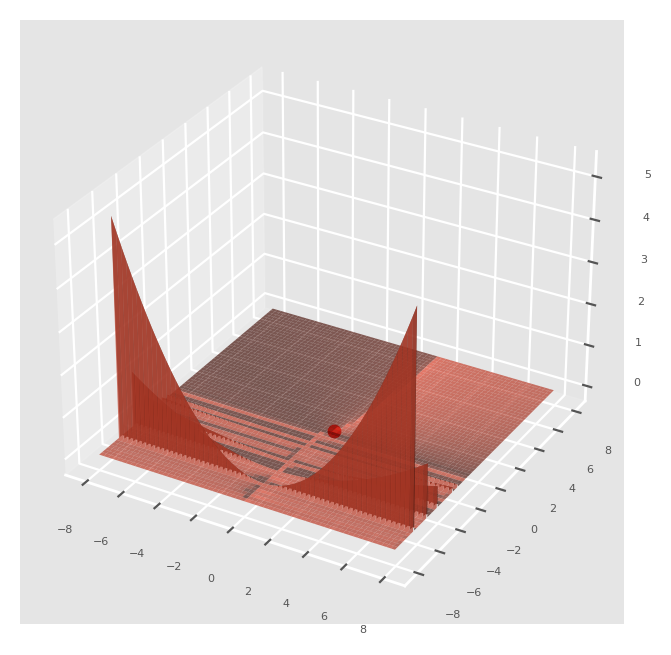

In [11]:
rational_loss = lambda a, b: least_squares(rational_approximant, a, b)

rational_gradient_result = custom_gradient(rational_loss, draw=True)

In [12]:
rational_gradient_result

{'min_args': [0.5400076804258992, -0.6130347262042257],
 'min_value': (0.5400076804258992, -0.6130347262042257, 1.6555773161416876),
 'n_steps': 234,
 'n_function_callings': 297804}

In [13]:
rational_loss(*rational_gradient_result['min_args'])

1.6555773161416876

In [14]:
results = {'gradient': {'linear': linear_gradient_result, 'rational': rational_gradient_result}}

In [15]:
results

{'gradient': {'linear': {'min_args': [0.8804550695731, 0.39594224404466294],
   'min_value': (0.8804550695731, 0.39594224404466294, 1.1281966384841717),
   'n_steps': 42,
   'n_function_callings': 145230},
  'rational': {'min_args': [0.5400076804258992, -0.6130347262042257],
   'min_value': (0.5400076804258992, -0.6130347262042257, 1.6555773161416876),
   'n_steps': 234,
   'n_function_callings': 297804}}}

# Non-linear Conjugate Gradient Descent

     fun: 1.126366117276201
     jac: array([0.0183924, 0.049772 ])
 message: 'Desired error not necessarily achieved due to precision loss.'
    nfev: 162
     nit: 2
    njev: 50
  status: 2
 success: False
       x: array([0.89417523, 0.38693928])


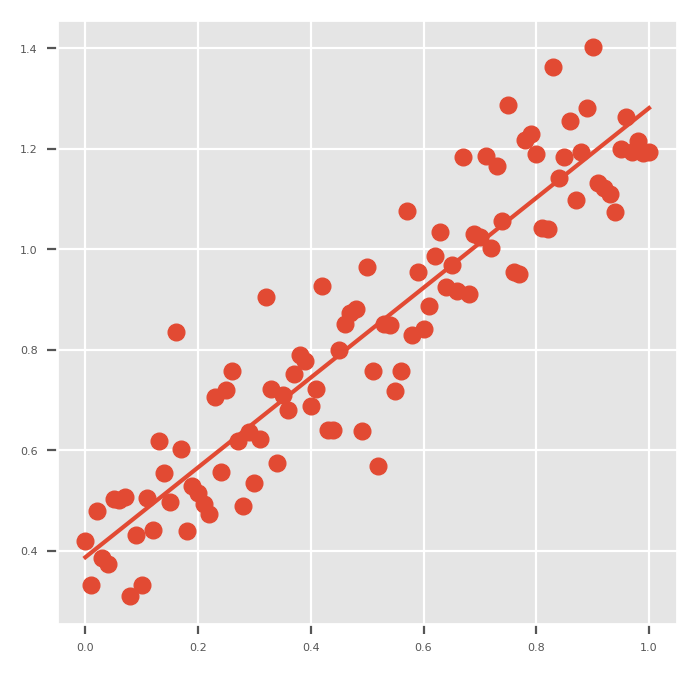

In [32]:
import scipy.optimize as opt

def CG(F, a0=0.0, b0=0.0, eps = 0.001):
    res = opt.minimize(lambda x: least_squares(F, x[0], x[1]), x0=(a0, b0), method='CG', options={'eps': eps})
    return res

estimation_CG_lin = CG(linear_approximant)

print(estimation_CG_lin)
plot_aproximant(lambda x: linear_approximant(x, estimation_CG_lin.x[0], estimation_CG_lin.x[1]))
plt.show()

     fun: 1.6552258468956458
     jac: array([-0.00749018,  0.02086076])
 message: 'Desired error not necessarily achieved due to precision loss.'
    nfev: 183
     nit: 11
    njev: 57
  status: 2
 success: False
       x: array([ 0.5406299 , -0.61213704])


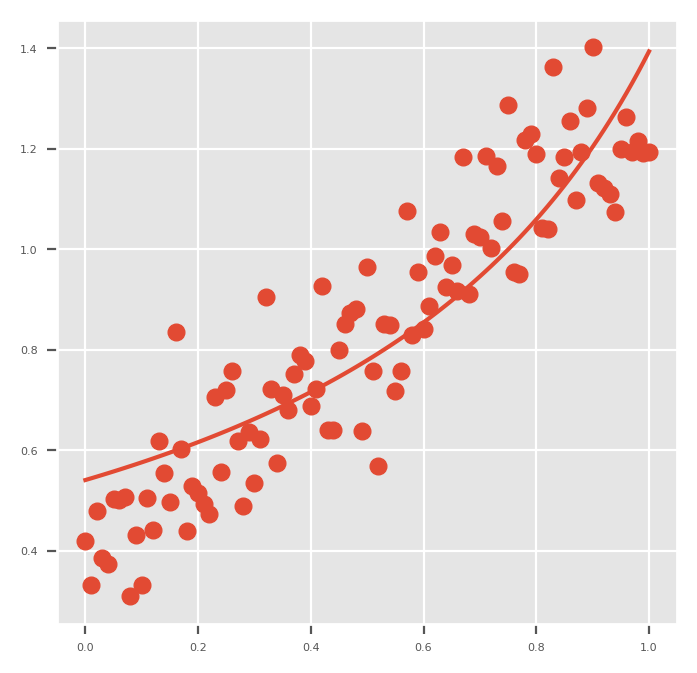

In [33]:
estimation_CG_rat = CG(rational_approximant)

print(estimation_CG_rat)
plot_aproximant(lambda x: rational_approximant(x, estimation_CG_rat.x[0], estimation_CG_rat.x[1]))
plt.show()

In [34]:
results['CG'] = {'linear': estimation_CG_lin, 'rational': estimation_CG_rat}

# Newton’s method

     fun: 1.1263566087281136
     jac: array([-1.80659307e-13,  3.15636406e-13])
 message: 'Optimization terminated successfully.'
    nfev: 4
    nhev: 0
     nit: 3
    njev: 9
  status: 0
 success: True
       x: array([0.89358283, 0.38748908])


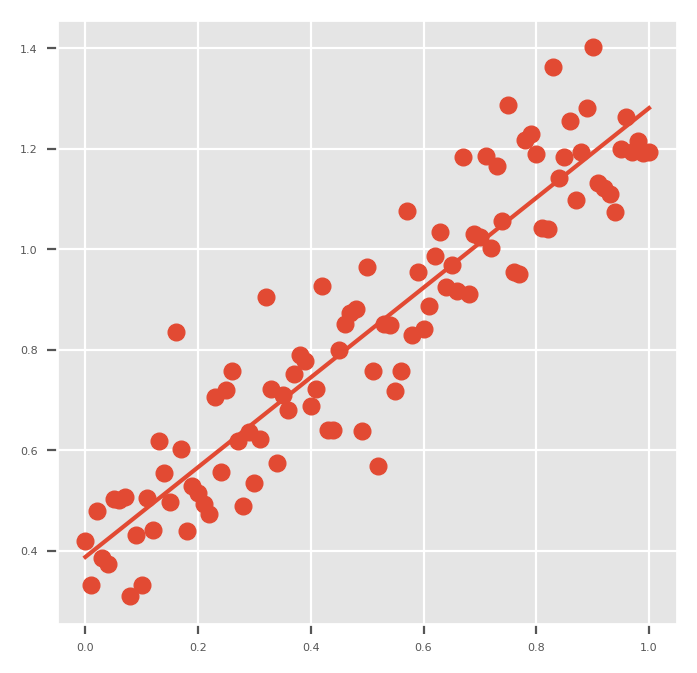

In [35]:
import autograd.numpy as np
from autograd import grad, jacobian
x = np.array([5,3], dtype=float)
def cost(x):
    return least_squares(linear_approximant, x[0], x[1])
gradient_cost = grad(cost)
jacobian_cost = jacobian(cost)
gradient_cost(x)
jacobian_cost(np.array([x, x, x]))

def Newton_CG(F, a0=0.0, b0=0.0, eps = 0.001):
  def cost(x):
    return least_squares(F, x[0], x[1])
  jacobian_cost = jacobian(cost)
  res = opt.minimize(cost, x0=(a0, b0), method='Newton-CG', jac=jacobian_cost, options={'eps': eps})
  return res
  
estimation_Newton_CG_lin = Newton_CG(linear_approximant)

print(estimation_Newton_CG_lin)
plot_aproximant(lambda x: linear_approximant(x, estimation_Newton_CG_lin.x[0], estimation_Newton_CG_lin.x[1]))
plt.show()

     fun: 1.6545522976810976
     jac: array([ 7.89583376e-05, -1.53887085e-04])
 message: 'Optimization terminated successfully.'
    nfev: 11
    nhev: 0
     nit: 9
    njev: 32
  status: 0
 success: True
       x: array([ 0.54359246, -0.60866072])


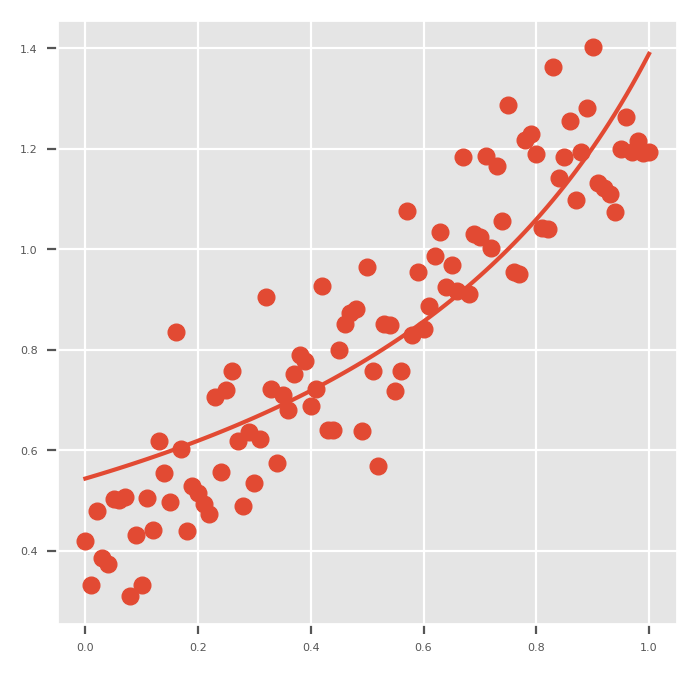

In [36]:
estimation_Newton_CG_rat = Newton_CG(rational_approximant)

print(estimation_Newton_CG_rat)
plot_aproximant(lambda x: rational_approximant(x, estimation_Newton_CG_rat.x[0], estimation_Newton_CG_rat.x[1]))
# plot_aproximant(lambda x: rational_approximant(x, estimation_CG_rat.x[0], estimation_CG_rat.x[1]))
plt.show()

In [37]:
results['Newton'] = {'linear': estimation_Newton_CG_lin, 'rational': estimation_Newton_CG_rat}

# Levenberg-Marquardt

In [42]:
import autograd.numpy as np
from autograd import grad, jacobian
x = np.array([5,3], dtype=float)
def cost(x):
    return least_squares(linear_approximant, x[0], x[1])
gradient_cost = grad(cost)
jacobian_cost = jacobian(cost)
gradient_cost(x)
jacobian_cost(np.array([x, x, x]))

array([[[ 743.74485207,    0.        ],
        [1346.47533868,    0.        ],
        [   0.        ,    0.        ]],

       [[   0.        ,  406.40485207],
        [   0.        ,  740.47533868],
        [   0.        ,    0.        ]]])

In [43]:
jacobian_cost

<function autograd.wrap_util.unary_to_nary.<locals>.nary_operator.<locals>.nary_f(*args, **kwargs)>

In [44]:
gradient_cost(x)

array([541.74485207, 942.47533868])

In [46]:
import autograd.numpy as np
from autograd import grad, jacobian
x = np.array([5,3], dtype=float)
def cost(x):
    return x[0]**2 / x[1] - np.log(x[1])
gradient_cost = grad(cost)
jacobian_cost = jacobian(cost)
gradient_cost(x)
jacobian_cost(np.array([x,x]))

array([[[ 2.        ,  0.        ],
        [-1.2       ,  0.        ]],

       [[ 0.        ,  2.        ],
        [ 0.        , -1.33333333]]])

[[ 0.7694016  -1.31779401]
 [ 0.4794016  -1.60779401]]


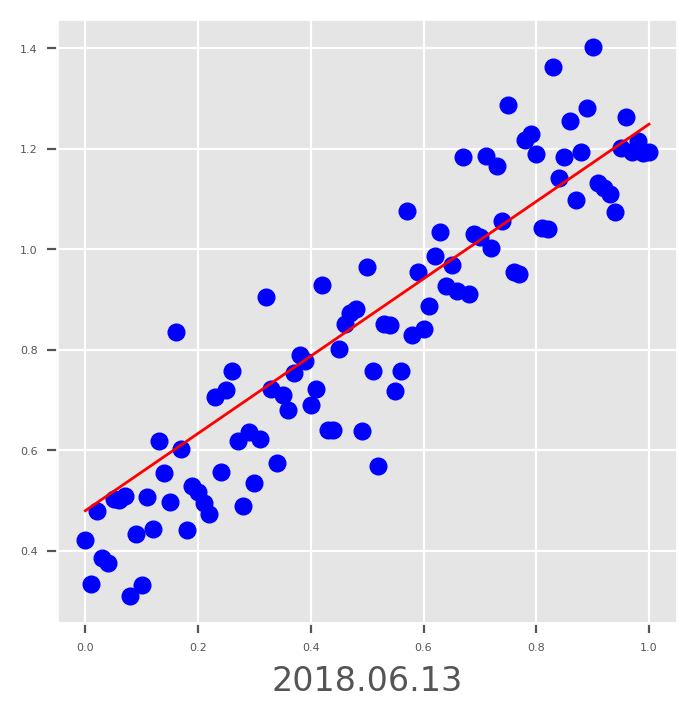

35


In [49]:
'''
#Implement LM algorithm only using basic python
#Author:Leo Ma
#For csmath2019 assignment4,ZheJiang University
#Date:2019.04.28
'''
import numpy as np
import matplotlib.pyplot as plt 

#input data, whose shape is (num_data,1)
#data_input=np.array([[0.25, 0.5, 1, 1.5, 2, 3, 4, 6, 8]]).T
#data_output=np.array([[19.21, 18.15, 15.36, 14.10, 12.89, 9.32, 7.45, 5.24, 3.01]]).T


tao = 10**-3
threshold_stop = 10**-15
threshold_step = 10**-15
threshold_residual = 10**-15



#construct a user function
def my_Func(params,input_data):
    a = params[0,0]
    b = params[1,0]
    #c = params[2,0]
    #d = params[3,0]
    return a*np.exp(b*input_data)
    #return a*np.sin(b*input_data[:,0])+c*np.cos(d*input_data[:,1])

# def my_Func(params, input_data):
#       print("Found Bug")

    
#generating the input_data and output_data,whose shape both is (num_data,1)
def generate_data(params,num_data):
    x = np.array (np.linspace (0,10, num_data)). reshape (num_data, 1) # Генерация данных, содержащих шум
    mid,sigma = 0,5
    y = my_Func(params,x) + np.random.normal(mid, sigma, num_data).reshape(num_data,1)
    return x,y
    

#calculating the derive of pointed parameter,whose shape is (num_data,1)
def cal_deriv(params,input_data,param_index, func):
    params1 = params.copy()
    params2 = params.copy()
    params1[param_index,0] += 0.000001
    params2[param_index,0] -= 0.000001
    data_est_output1 = func(params1,input_data)
    data_est_output2 = func(params2,input_data)
    return (data_est_output1 - data_est_output2) / 0.000002

#calculating jacobian matrix,whose shape is (num_data,num_params)
def cal_Jacobian(params,input_data, func):
    num_params = np.shape(params)[0]
    num_data = np.shape(input_data)[0]
    J = np.zeros((num_data,num_params))
    for i in range(0,num_params):
            J[:,i] = list(cal_deriv(params,input_data,i, func))
    return J

#calculating residual, whose shape is (num_data,1)
def cal_residual(params,input_data,output_data,func):
    data_est_output = func(params,input_data)
    residual = output_data - data_est_output
    return residual
    

'''    
#calculating Hessian matrix, whose shape is (num_params,num_params)
def cal_Hessian_LM(Jacobian,u,num_params):
    H = Jacobian.T.dot(Jacobian) + u*np.eye(num_params)
    return H
    
#calculating g, whose shape is (num_params,1)
def cal_g(Jacobian,residual):
    g = Jacobian.T.dot(residual)
    return g

#calculating s,whose shape is (num_params,1)
def cal_step(Hessian_LM,g):
    s = Hessian_LM.I.dot(g)
    return s
     
'''


#get the init u, using equation u=tao*max(Aii)
def get_init_u(A,tao):
    m = np.shape(A)[0]
    Aii = []
    for i in range(0,m):
        Aii.append(A[i,i])
    u = tao*max(Aii)
    return u
    
#LM algorithm
def LM(num_iter,params,input_data,output_data,func, eps=0.001):
    loss_memory = []
    loss = np.inf
    prev_loss = np.inf
    num_params = np.shape(params)[0] #the number of params
    k = 0 #set the init iter count is 0
    #calculating the init residual
    n_calls = 1
    residual = cal_residual(params,input_data,output_data,func)
    #calculating the init Jacobian matrix
    Jacobian = cal_Jacobian(params,input_data, func)
    
    A = Jacobian.T.dot(Jacobian) #calculating the init A
    g = Jacobian.T.dot(residual) #calculating the init gradient g
    stop = (np.linalg.norm(g, ord=np.inf) <= threshold_stop) #set the init stop
    u = get_init_u(A,tao) #set the init u
    v = 2 #set the init v=2
    
    while(True):
        k+=1
        Hessian_LM = A + u*np.eye(num_params) #calculating Hessian matrix in LM
        step = np.linalg.inv(Hessian_LM).dot(g) #calculating the update step
        # print("Step: ", step)
        # if(np.linalg.norm(step) <= threshold_step):
        if abs(loss-prev_loss)<eps:
            stop = True
        else:
            new_params = params + step #update params using step
            new_residual = cal_residual(new_params,input_data,output_data, func) #get new residual using new params
            n_calls+=1
            rou = (np.linalg.norm(residual)**2 - np.linalg.norm(new_residual)**2) / (step.T.dot(u*step+g))
            if rou > 0:
                params = new_params
                residual = new_residual
                prev_loss = loss
                loss = np.linalg.norm(residual)**2
                loss_memory.append(loss)
                #print (np.linalg.norm(new_residual)**2)
                Jacobian = cal_Jacobian(params,input_data, func)#recalculating Jacobian matrix with new params
                A = Jacobian.T.dot(Jacobian)#recalculating A
                g = Jacobian.T.dot(residual)#recalculating gradient g
                stop = (np.linalg.norm(g, ord=np.inf) <= threshold_stop) or (np.linalg.norm(residual)**2 <= threshold_residual)
                u = u*max(1/3,1-(2*rou-1)**3)
                v = 2
            else:
                u = u*v
                v = 2*v
        # if(rou > 0 or stop):
        if stop:
            break;
        
    return params, k, n_calls, loss
  


        
        
# #set the true params for generate_data() function
params = np.zeros((2,1))
# params[0,0]=10.0
# params[1,0]=0.8
# num_data = 100# set the data number
# data_input,data_output = generate_data(params,num_data)#generate data as requested

#set the init params for LM algorithm 
# params[0,0]=6.0
# params[1,0]=0.3

params[0,0]=0.55
params[1,0]=0.26

#using LM algorithm estimate params
num_iter=500    # the number of iteration
# est_params = LM(num_iter,params,data_input,data_output, func=my_Func)

def lin_LM(params, input_data):
    return params[0,0]*input_data+params[1,0]

est_params, n_iters, n_calls, total_loss = LM(num_iter,params,X,Y, func=lin_LM)
print(est_params)
a_est=est_params[0,0]
b_est=est_params[1,0]


      #   Нарисуйте картинку, чтобы увидеть ситуацию
plt.scatter(X, Y, color='b')
# x = np.arange(0, 100) * 0.1 # Создать всего 100 данных от 0 до 10, а затем установить интервал на 0,1
# plt.plot(x,a_est*np.exp(b_est*x),'r',lw=1.0)
plt.plot(X,a_est*X+b_est,'r',lw=1.0)
plt.xlabel("2018.06.13")
plt.savefig("result_LM.png")
plt.show()

# plt.plot(residual_memory)
# plt.xlabel("2018.06.13")
# plt.savefig("error-iter.png")
# plt.show()
print(n_iters)

In [50]:
results['LMA'] = {'linear': {'x': [a_est, b_est], 'nit': n_iters, 'loss': linear_loss(a_est, b_est)}}

In [51]:
results

{'gradient': {'linear': {'min_args': [0.8804550695731, 0.39594224404466294],
   'min_value': (0.8804550695731, 0.39594224404466294, 1.1281966384841717),
   'n_steps': 42,
   'n_function_callings': 145230},
  'rational': {'min_args': [0.5400076804258992, -0.6130347262042257],
   'min_value': (0.5400076804258992, -0.6130347262042257, 1.6555773161416876),
   'n_steps': 234,
   'n_function_callings': 297804}},
 'CG': {'linear':      fun: 1.126366117276201
       jac: array([0.0183924, 0.049772 ])
   message: 'Desired error not necessarily achieved due to precision loss.'
      nfev: 162
       nit: 2
      njev: 50
    status: 2
   success: False
         x: array([0.89417523, 0.38693928]),
  'rational':      fun: 1.6552258468956458
       jac: array([-0.00749018,  0.02086076])
   message: 'Desired error not necessarily achieved due to precision loss.'
      nfev: 183
       nit: 11
      njev: 57
    status: 2
   success: False
         x: array([ 0.5406299 , -0.61213704])},
 'Newton': {'

[[ 0.55881746  0.40284092]
 [-0.54118254 -0.69715908]]


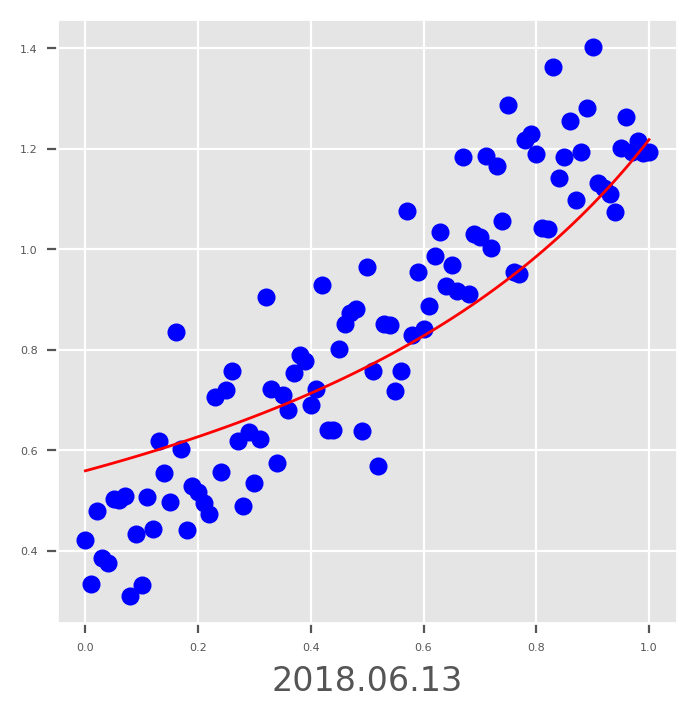

iterations:  11
loss:  2.038294282643526


In [52]:
def rat_LM(params, input_data):
    a = params[0,0]
    b = params[1,0]
    return a/(1+b*input_data)

# 0.34842363, -0.59916188
params[0,0]=0.5
params[1,0]=-0.6

est_params, n_iters, n_calls, total_loss = LM(num_iter,params,X,Y, func=rat_LM)
print(est_params)
a_est=est_params[0,0]
b_est=est_params[1,0]

plt.scatter(X, Y, color='b')
plt.plot(X,rat_LM(est_params, X),'r',lw=1.0)
plt.xlabel("2018.06.13")
plt.savefig("result_LM.png")
plt.show()

# plt.plot(residual_memory)
# plt.xlabel("2018.06.13")
# plt.savefig("error-iter.png")
# plt.show()
print("iterations: ", n_iters)
print("loss: ", rational_loss(a_est, b_est))

0.8894063538929593 0.39022451476400943


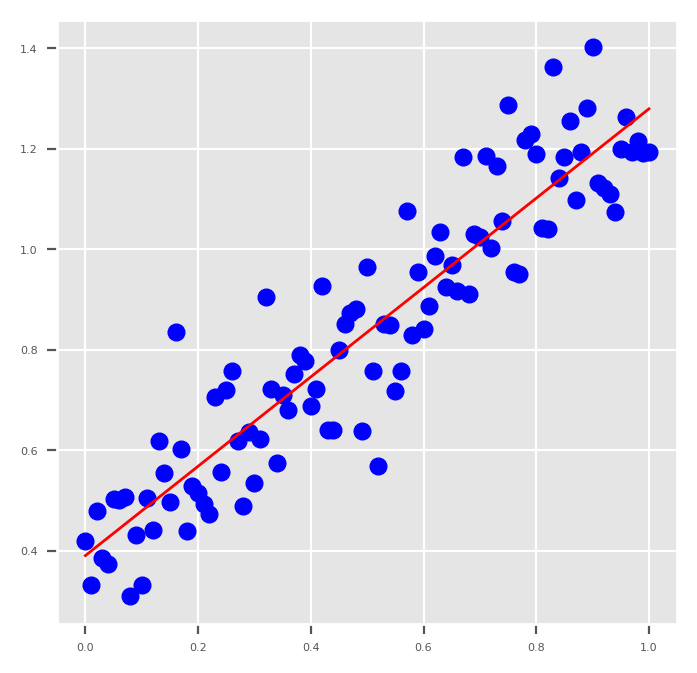

In [53]:
print(alpha, beta)
plt.scatter(X, Y, color='b')
plt.plot(X,alpha*X+beta,'r',lw=1.0)

In [54]:
results['LMA']['rational'] = {'x': [a_est, b_est], 'nit': n_iters, 'loss': rational_loss(a_est, b_est)}

In [55]:
 results

{'gradient': {'linear': {'min_args': [0.8804550695731, 0.39594224404466294],
   'min_value': (0.8804550695731, 0.39594224404466294, 1.1281966384841717),
   'n_steps': 42,
   'n_function_callings': 145230},
  'rational': {'min_args': [0.5400076804258992, -0.6130347262042257],
   'min_value': (0.5400076804258992, -0.6130347262042257, 1.6555773161416876),
   'n_steps': 234,
   'n_function_callings': 297804}},
 'CG': {'linear':      fun: 1.126366117276201
       jac: array([0.0183924, 0.049772 ])
   message: 'Desired error not necessarily achieved due to precision loss.'
      nfev: 162
       nit: 2
      njev: 50
    status: 2
   success: False
         x: array([0.89417523, 0.38693928]),
  'rational':      fun: 1.6552258468956458
       jac: array([-0.00749018,  0.02086076])
   message: 'Desired error not necessarily achieved due to precision loss.'
      nfev: 183
       nit: 11
      njev: 57
    status: 2
   success: False
         x: array([ 0.5406299 , -0.61213704])},
 'Newton': {'

In [77]:
results['CG']['linear']['x'][0]

0.8941752281333375

In [69]:
linear_approximant

<function __main__.linear_approximant(x, a=0.0, b=0.0)>

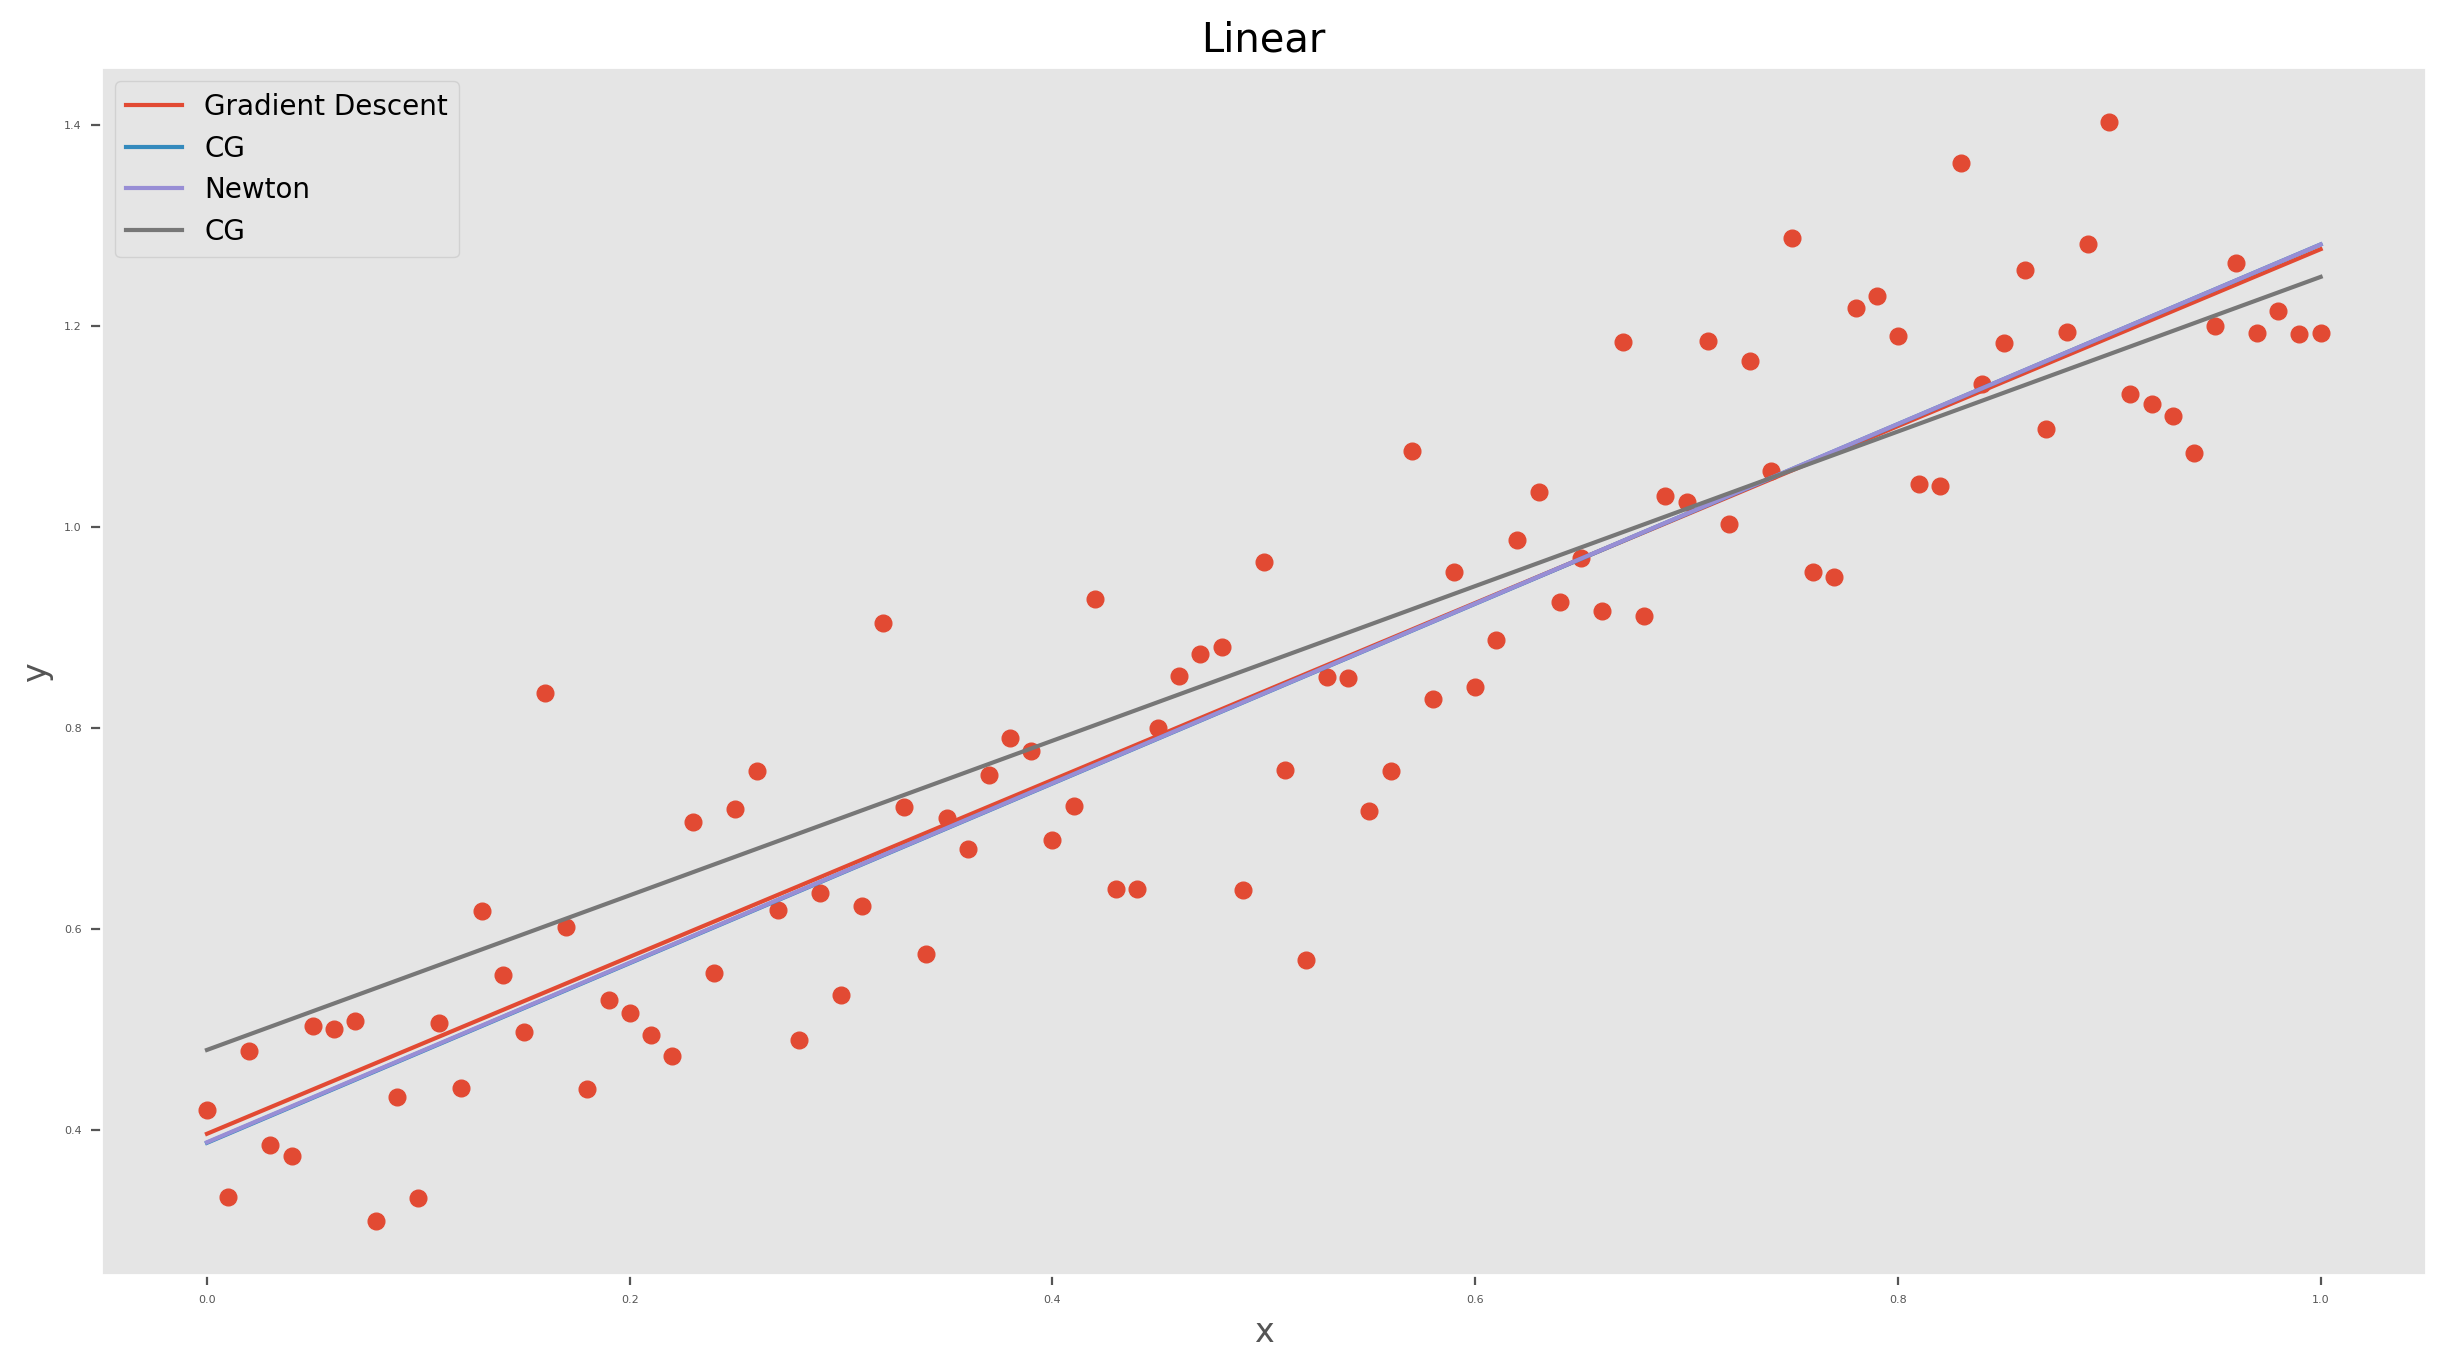

In [81]:
figure = plt.figure(figsize=(15,8))
plt.scatter(X,Y)
plt.plot(X, linear_approximant(X, results['gradient']['linear']['min_args'][0], results['gradient']['linear']['min_args'][1]), label='Gradient Descent')
plt.plot(X, linear_approximant(X, results['CG']['linear']['x'][0], results['CG']['linear']['x'][1]), label='CG')
plt.plot(X, linear_approximant(X, results['Newton']['linear']['x'][0], results['Newton']['linear']['x'][1]), label='Newton')
plt.plot(X, linear_approximant(X, results['LMA']['linear']['x'][0], results['LMA']['linear']['x'][1]), label='LMA')

plt.grid()
plt.xlabel('x')
plt.ylabel('y')
plt.title("Linear")
plt.legend()

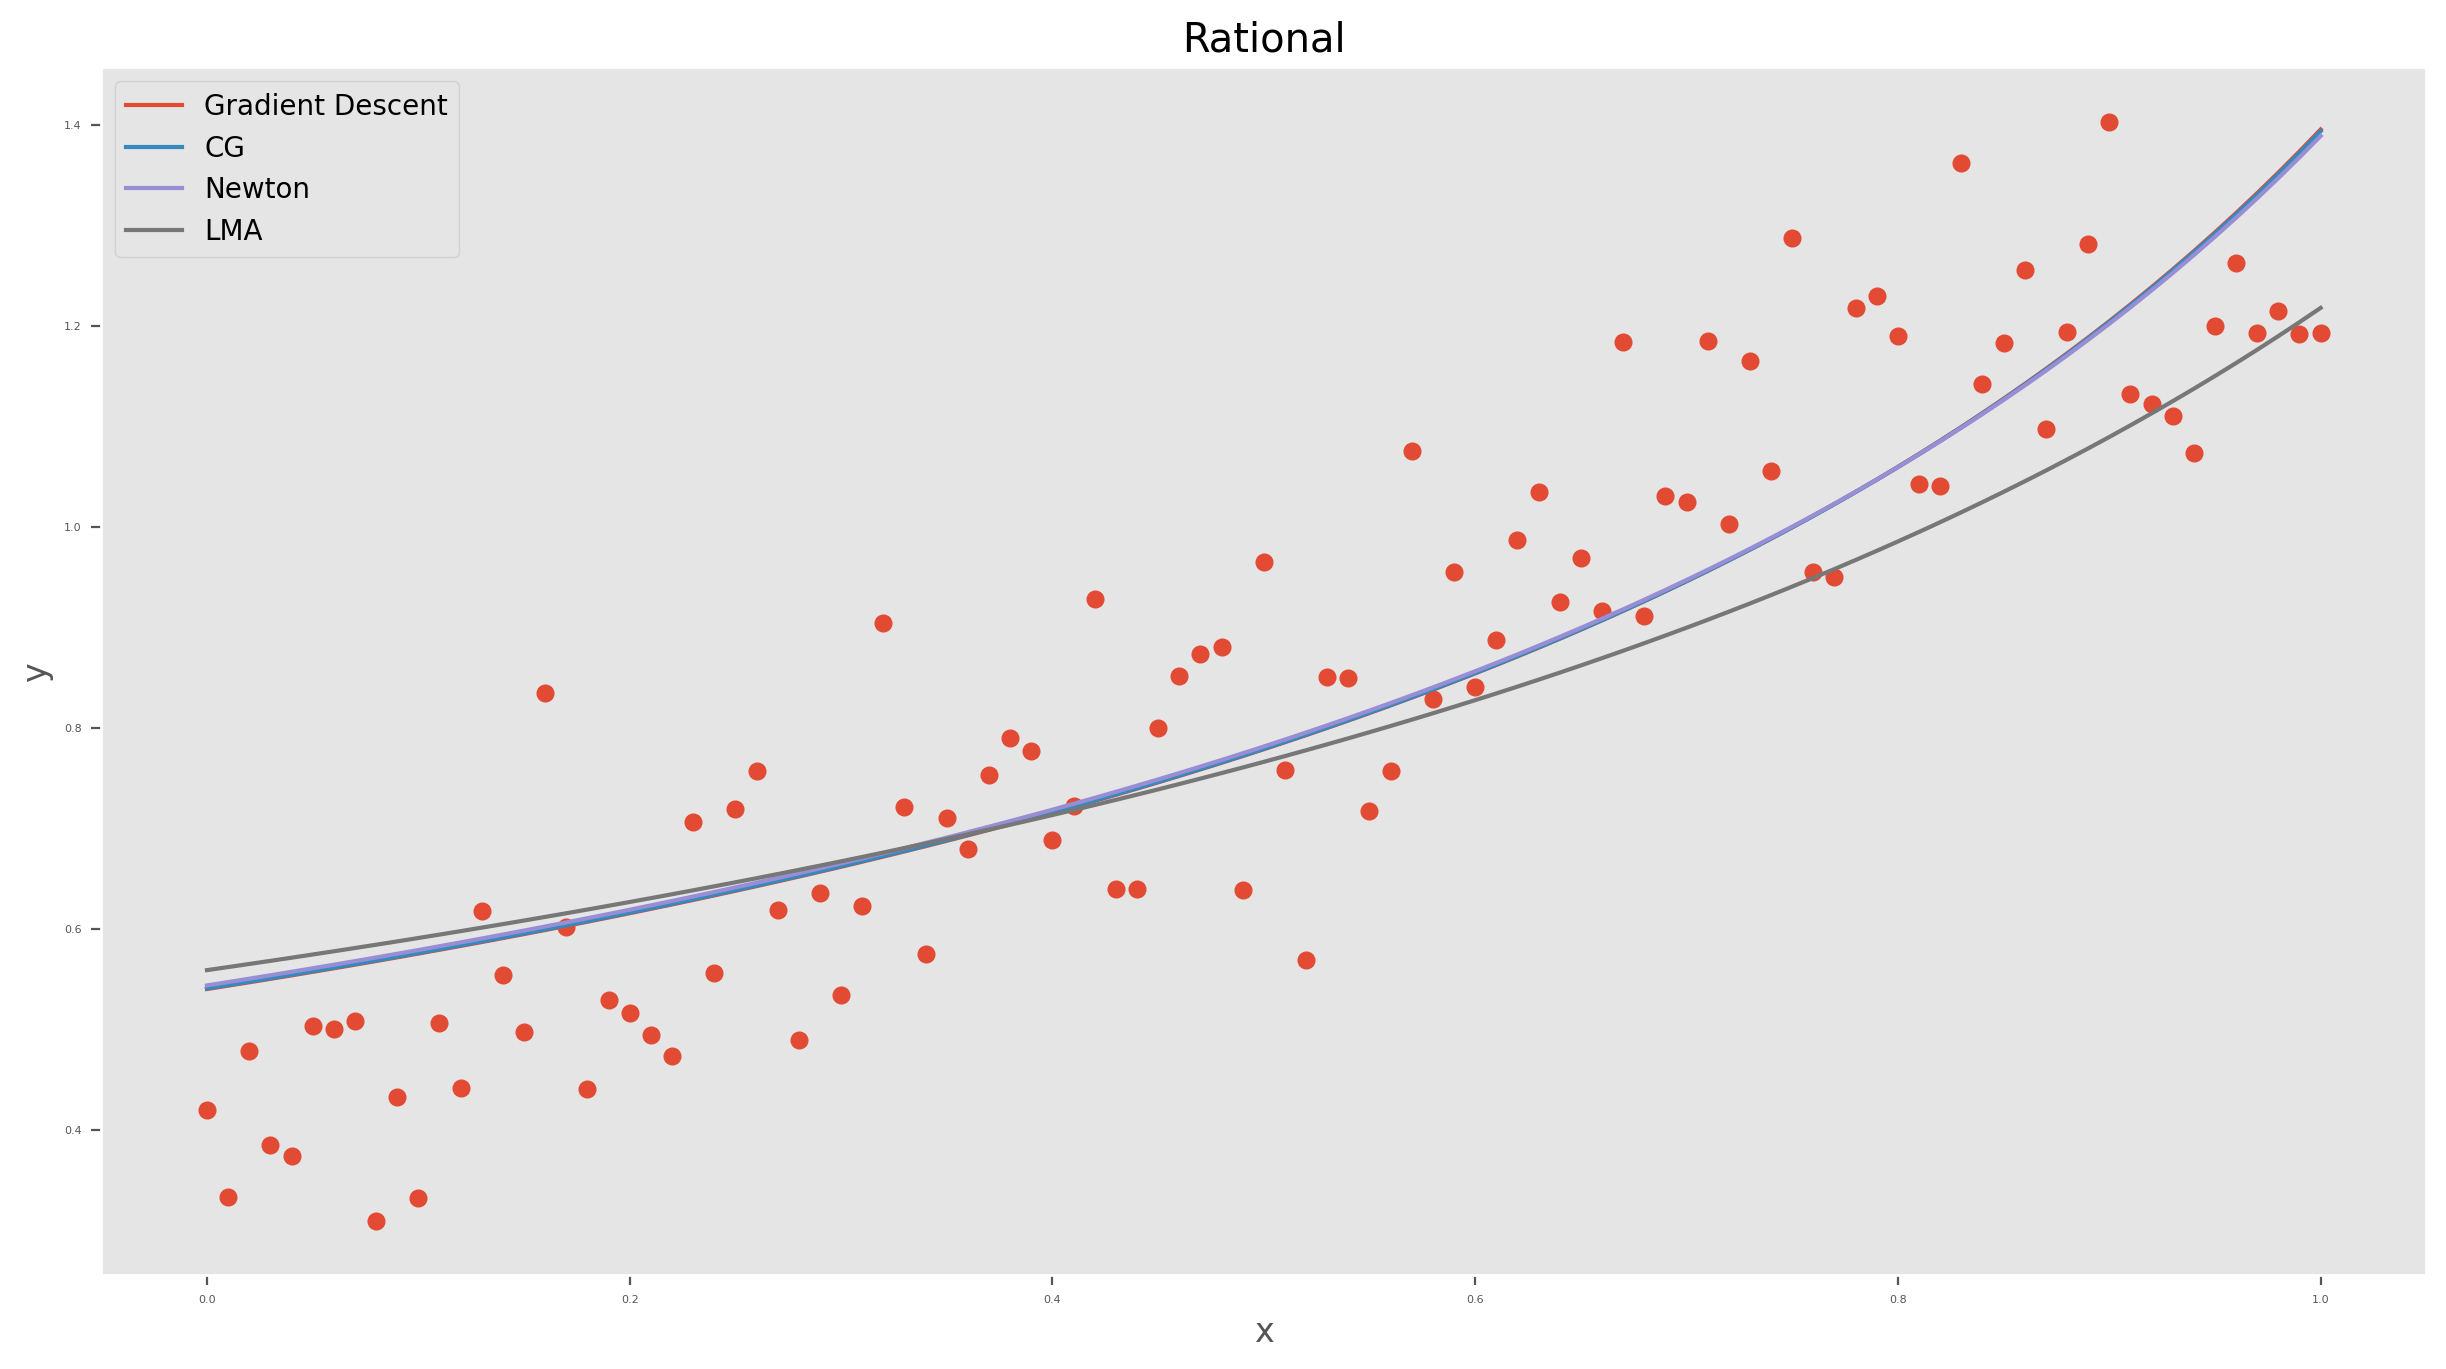

In [85]:
figure = plt.figure(figsize=(15,8))
plt.scatter(X,Y)
plt.plot(X, rational_approximant(X, results['gradient']['rational']['min_args'][0], results['gradient']['rational']['min_args'][1]), label='Gradient Descent')
plt.plot(X, rational_approximant(X, results['CG']['rational']['x'][0], results['CG']['rational']['x'][1]), label='CG')
plt.plot(X, rational_approximant(X, results['Newton']['rational']['x'][0], results['Newton']['rational']['x'][1]), label='Newton')
plt.plot(X, rational_approximant(X, results['LMA']['rational']['x'][0], results['LMA']['rational']['x'][1]), label='LMA')

plt.grid()
plt.xlabel('x')
plt.ylabel('y')
plt.title("Rational")
plt.legend()